## Семинар 6 "Segmentation"

ФИО: __Иванов Иван Иванович__

## Задание

Предлагается поучаствовать в конкурсе https://drive.grand-challenge.org/

Для зачета требуется получить значение dice-coefficient на leaderboard не меньше 0.8 и прислать ноутбук с кодом и кратким отчетом: что пробовали, что сделали, мысли почему окончательная архитектура лучше остальных.

Называйте своего юзера с суффиксом [sphere].

Также первые 3 человека получат бонусные 6, 4, 2 балл соответственно. (deadline: 23:59 14 апреля 2019). Скорее всего будут дополнительные плюшки для призеров конкурса.


In [42]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.models import resnet50
import torch as t
from torch.utils import data
from torchvision import transforms as tsf
import scipy.misc
import torch.nn as nn
from pathlib import Path
from keras.layers import GaussianNoise
from PIL import Image
import skimage
from skimage import io
from torchvision import models
import torch
from sklearn.model_selection import train_test_split
from torchvision.models import resnet50
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from torch.nn import CrossEntropyLoss, Sequential, Linear, Sigmoid, Tanh, BCELoss, Softmax, BatchNorm1d
from torch.utils.data.sampler import Sampler, SubsetRandomSampler, WeightedRandomSampler
from PIL import Image # Replace by accimage when ready
from PIL.Image import FLIP_LEFT_RIGHT, FLIP_TOP_BOTTOM, ROTATE_90, ROTATE_180, ROTATE_270
from PIL.ImageEnhance import Color, Contrast, Brightness, Sharpness
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
img_size=512
TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'
%matplotlib inline

In [30]:
def process(dataset_path, mask_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image)
        
        if img.shape[2]>3:
            assert(img[:,:,3]!=255).sum()==0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0]
        item['img'] = t.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path/(item['name'] + "_manual1.gif"))
            item['mask'] = t.from_numpy(mask)
        data.append(item)
    
    return data
test = process('test/images/')
t.save(test, TEST_PATH)
train_data = process('train/images', "train/1st_manual/")
control_data = process('train/control/images', "train/control/1st_manual/")

In [43]:
import PIL
class Dataset():
    def __init__(self,data,source_transform,target_transform):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask
    def __len__(self):
        return len(self.datas)
s_trans = tsf.Compose([
    tsf.ToPILImage(),
                tsf.Resize((img_size,img_size)),
                 tsf.ToTensor(),
                 tsf.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])
])
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((img_size,img_size),interpolation=PIL.Image.NEAREST),
    tsf.ToTensor(),]
)
dataset = Dataset(train_data,s_trans,t_trans)
train_dataloader = t.utils.data.DataLoader(dataset,batch_size=4)
control_dataloader = t.utils.data.DataLoader(Dataset(control_data,s_trans,t_trans), batch_size=4,shuffle=True)

In [44]:
for X,Y in train_dataloader:
    print(X.shape,Y.shape)

torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])
torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])
torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])
torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])
torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])
torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])
torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])
torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])
torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])
torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])
torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])
torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])
torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])
torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])
torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])
torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])
torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])
torch.Size([4,

W1030 15:16:17.320329   260 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


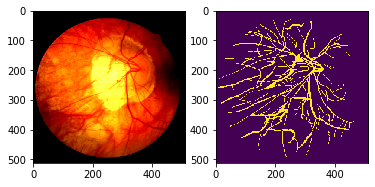

In [46]:
img,mask = dataset[80]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())

In [47]:
# sub-parts of the U-Net model

from torch import nn
import torch.nn.functional as F


class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = t.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 1024)
        self.up1 = up(1024, 512)
        self.up2 = up(512, 256)
        self.up3 = up(256, 128)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = t.nn.functional.sigmoid(x)
        return x

In [48]:
# Попробуйте использовать различные функции потерь.
def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
        score = 1 - score.sum()/num
        return score

In [49]:
class UNet_(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)  

        self.maxpool = nn.MaxPool2d(2)
        
        self.dconv_up3 = double_conv(512, 256)
        self.dconv_up2 = double_conv(256, 128)
        self.dconv_up1 = double_conv(128, 64)
        
        self.TConv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.TConv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.TConv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        
        x = self.dconv_down4(x)
        
        x = self.TConv3(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.TConv2(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.TConv1(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)
        out = self.conv_last(x)
        out = F.sigmoid(out)
        
        return out

In [50]:
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)
trans = tsf.Compose([
    tsf.ToPILImage(),
                tsf.Resize((img_size,img_size)),
                 tsf.ToTensor(), 
                 tsf.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
testset = TestDataset(TEST_PATH, trans)
testdataloader = t.utils.data.DataLoader(testset,batch_size=1)

In [53]:
model = UNet_(n_class=1)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-2)
criterion = soft_dice_loss
model.train()

UNet_(
  (dconv_down1): double_conv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (dconv_down2): double_conv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (dconv_down3): double_conv(
    (conv): Sequential(
      (0): Conv

In [51]:
model = UNet(n_channels=3,n_classes=1)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = soft_dice_loss
model.train()

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2

In [54]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
#dtype = torch.cuda.FloatTensor
dtype = torch.FloatTensor
model.train()

num_epochs = 400

for epoch in range(num_epochs):
    running_loss = []
    control_loss =[]
    for i, (X, y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)
        X = Variable(X)
        y = Variable(y)
        
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        
        loss.backward()
        optimizer.step()
        running_loss.append(loss.item())
        
    for i, (X, y) in enumerate(control_dataloader):
        X = X.to(device)
        y = y.to(device)
        X = Variable(X)
        y = Variable(y)
        
        output = model(X)
        loss_ = criterion(output, y)
        control_loss.append(loss_.item())

    print("loss for epoch " + str(epoch) + ":  " + str(np.mean(running_loss))+",  " + str(np.mean(control_loss)))


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1207959552 bytes. Buy new RAM!


W1030 14:55:20.796738   260 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


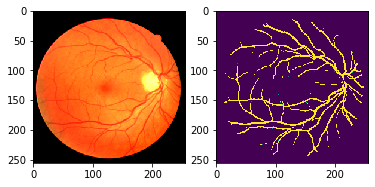

In [20]:
model.eval()

x = testset[1]
plt.subplot(121)
plt.imshow(x.permute(1,2,0).numpy()*0.5+0.5)
x = x.unsqueeze(0)
x = x.cuda()
pred = model(x)

pred = pred.squeeze(0)
pred = pred.squeeze(0)
plt.subplot(122)
plt.imshow(pred.cpu().detach().numpy())

In [22]:
os.makedirs("result")
!zip -r result.zip result

"zip" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [23]:
model = model.eval()
with torch.no_grad():
    for ex_id, data in enumerate(testdataloader):
        data = t.autograd.Variable(data, volatile=True).cuda()
        o = model(data).cpu()
    
        source_image = io.imread("test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
        tm = o[0][0].data.cpu().numpy()
        tm = skimage.transform.resize(tm, source_image.shape[:-1])
        tm = (tm > 0.5).astype(int)
        scipy.misc.imsave("result/%s.png" % (ex_id + 1), tm)

C:\Users\vkrin\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.
C:\Users\vkrin\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:2616: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
C:\Users\vkrin\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  # This is added back by InteractiveShellApp.init_path()


W1030 14:55:57.187280   260 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


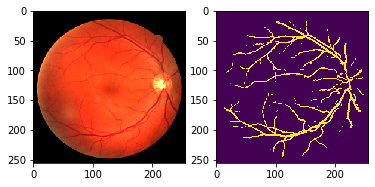

In [24]:
tm=o[0][0].data.cpu().numpy()
plt.subplot(121)
plt.imshow(data[0].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(tm)

In [25]:
!zip -r result.zip result

"zip" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
